In [1]:
import pandas as pd
import numpy as np
import subprocess as sp
import os

The raw data contains BAM files for each cluster (not copied here), as well as a table of peaks.
We can use these to obtain a table of reads under peaks using gimmemotifs' coverage_table command.

In [2]:
%%bash

coverage_table -h

usage: coverage_table [-h] -p FILE -d [FILE ...] [-w WINDOW] [-l] [-n METHOD]
                      [-t TOP] [-T TOPMETHOD] [-D] [-R] [--nthreads INT]

GimmeMotifs v0.17.0+8.g3168ca1 - coverage_table

optional arguments:
  -h, --help            show this help message and exit
  -p FILE, --peaks FILE
                        BED file containing peaks
  -d [FILE ...], --datafile [FILE ...]
                        data files (BAM, BED or bigWig format)
  -w WINDOW, --window WINDOW
                        window size (default 200)
  -l, --logtransform    Log transfrom
  -n METHOD, --normalization METHOD
                        Normalization: none, quantile or scale
  -t TOP, --top TOP     Select regions.
  -T TOPMETHOD, --topmethod TOPMETHOD
                        Method to select regions (var, std, mean or random)
  -D                    keep duplicate reads (removed by default)
  -R                    keep reads with mapq 0 (removed by default)
  --nthreads INT        Number of threads


With this command we get the reads under peaks, with each peak normalized to 200bp (using the center of each read).

In [ ]:
%%bash

coverage_table \
-p raw/peaks.bed \
-d \
raw/Bam_Files_By_Cluster/DeduplicatedCluster0.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster1.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster2.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster3.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster4.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster5.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster6.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster7.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster8.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster9.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster10.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster11.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster12.bam \
raw/Bam_Files_By_Cluster/merged.bam \
-w 200 \
-n none \
--nthreads 24 \
> atac_counts_jordi.tsv

# get peak summits & max read depths

The peak file in the raw data has two issues:
  1. the peaks have variable widths
  2. some "peaks" have very few reads
  
Here we make a pileup of all BAM reads to find the number of reads, and the summit of reads under each peak. 

Next, we filter the peakset to peaks which contain at least four reads in total.

Finally, we normalize the peak width too 200bp, centered on the summit.

In [13]:
peakfile = "raw/peaks.bed"
df = pd.read_table(peakfile, comment="#", header=None)
df.columns = ["chrom", "start", "end"]
df

chrom     start       end
0      smed_chr1     13083     13927
1      smed_chr1     19611     20435
2      smed_chr1     20966     21970
3      smed_chr1     38884     40399
4      smed_chr1     43386     44289
...          ...       ...       ...
36617  smed_chr4  47085229  47086096
36618  smed_chr4  47087649  47088573
36619  smed_chr4  47091210  47091995
36620  smed_chr4  47093865  47094798
36621  smed_chr4  47099334  47100219

[36622 rows x 3 columns]

In [ ]:
# no comments/headers
df.to_csv("peaks.bed", sep="\t", index=False, header=False)

Optional: instead of using peaks.bed directly, you can extend the peaks first using bedtools slop. With 1000bp, all peaks have reads but that might be unrealistic. 

In [ ]:
%%bash

bedtools slop \
-b 1000 \
-i peaks.bed \
-g /bank/genomes/Smed/Smed.fa.sizes \
> peaks_extended.bed

In [ ]:
%%bash

# -B: Bam already filtered
# -A: Bam already filtered
samtools mpileup \
-A -B \
-l peaks_extended.bed \
-o peak_extended_pileup.tsv \
raw/Bam_Files_By_Cluster/merged.bam

In [36]:
pu = pd.read_table(
    "peak_extended_pileup.tsv", 
    header=None,
    usecols=[0,1,3],
    names=["chrom", "pos", "count"],
)

pu

chrom       pos  count
0         smed_chr1     12113      1
1         smed_chr1     12114      1
2         smed_chr1     12115      1
3         smed_chr1     12116      1
4         smed_chr1     12117      1
...             ...       ...    ...
21836233  smed_chr4  47101215     26
21836234  smed_chr4  47101216     26
21836235  smed_chr4  47101217     24
21836236  smed_chr4  47101218     24
21836237  smed_chr4  47101219     23

[21836238 rows x 3 columns]

In [ ]:
summits = []
depths = []
last_chrom = ""
for idx, (chrom, start, end) in df.iterrows():
    if last_chrom != chrom:
        print("chrom:", chrom)  # print progress
        chrom_pu = pu[pu["chrom"] == chrom]
        last_chrom = chrom
    
    sub_pu = chrom_pu[chrom_pu["pos"].between(start, end)]
    maxima = sub_pu["count"] == sub_pu["count"].max()
    if sum(maxima) == 0:
        summit = None
    elif sum(maxima) == 1:
        summit = int(sub_pu[maxima]["pos"])
    else:
        # middle_summit = sub_pu[maxima].index.to_series().median()
        idx = sub_pu[maxima].index
        middle_summit = idx[len(idx) // 2]
#         print(chrom, start, end)
#         print(sub_pu[maxima])
#         print(middle_summit)
#         print()
#         print(sub_pu.loc[[middle_summit]])
#         break
        summit = int(sub_pu.loc[middle_summit]["pos"])
    depth = sub_pu["count"].max()
    
    depths.append(depth)
    summits.append(summit)


In [38]:
df2 = df.copy()
df2["summit"] = summits
df2["depth"] = depths
df2 = df2.dropna()
df2["summit"] = df2["summit"].astype(np.int64)
df2["depth"] = df2["depth"].astype(np.int64)
df2.head()

chrom  start    end  summit  depth
0  smed_chr1  13083  13927   13380     24
1  smed_chr1  19611  20435   20370      6
2  smed_chr1  20966  21970   21047      5
3  smed_chr1  38884  40399   39983      4
4  smed_chr1  43386  44289   43931      2

In [ ]:
df2.to_csv("peak_extended_summits.tsv", index=False, sep="\t")

# visualize peaks per read depth

In [3]:
df2 = pd.read_csv("peak_summits.tsv", sep="\t")
# df2 = pd.read_csv("peak_extended_summits.tsv", sep="\t")

depth = list(range(0, df2["depth"].max()))
n_regions = []
for n in depth:
    nr = sum(df2['depth'] == n)
    n_regions.append(nr)
    if n <= 10:
        print(
            f"regions with depth {n}: {nr}"
        )


regions with depth 0: 1402
regions with depth 1: 8265
regions with depth 2: 9778
regions with depth 3: 5767
regions with depth 4: 3096
regions with depth 5: 1916
regions with depth 6: 1363
regions with depth 7: 920
regions with depth 8: 697
regions with depth 9: 510
regions with depth 10: 405


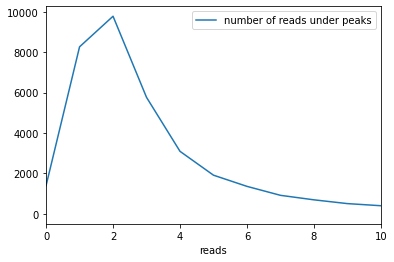

In [4]:
_ = pd.DataFrame({"reads": depth, "number of reads under peaks": n_regions}).plot(x="reads", xlim=(0, 10))#, ylim=(0, 20_000))

In [5]:
min_depth = list(range(0, df2["depth"].max()))
n_regions = []
for n in min_depth:
    nr = sum(df2['depth'] >= n)
    n_regions.append(nr)

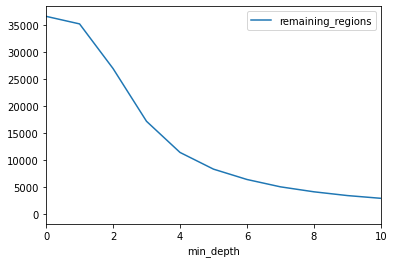

In [6]:
_ = pd.DataFrame({"min_depth": min_depth, "remaining_regions": n_regions}).plot(x="min_depth", xlim=(0, 10))#, ylim=(0, 20_000))

# filter peaks (by min read depth)

In [7]:
min_reads = 4

In [8]:
df3 = df2.copy()
df3 = df3[df3['depth'] >= min_reads]
# standardize the peak widths
df3["start"] = df3["summit"]-100
df3["end"] = df3["summit"]+100
df3 = df3[["chrom", "start", "end"]]
df3

chrom     start       end
0      smed_chr1     13280     13480
1      smed_chr1     20270     20470
2      smed_chr1     20947     21147
3      smed_chr1     39883     40083
5      smed_chr1     45661     45861
...          ...       ...       ...
36616  smed_chr4  47080857  47081057
36617  smed_chr4  47085665  47085865
36619  smed_chr4  47091552  47091752
36620  smed_chr4  47094534  47094734
36621  smed_chr4  47099397  47099597

[11410 rows x 3 columns]

In [ ]:
df3.to_csv(f"peaks_normalized_min{min_reads}.bed", index=False, header=False, sep="\t")

# visualize selected peaks in the trackhub

In [ ]:
bedname = f"peaks_normalized_min{min_reads}.bed"
sizes_file = "/bank/genomes/Smed/Smed.fa.sizes"
bigbedname = f"peaks_normalized_min{min_reads}.bb"

cmd = f"bedToBigBed -type=bed3 {bedname} {sizes_file} {bigbedname}"
print(cmd)
sp.call(cmd, shell=True)

cmd = f"rsync {bigbedname} cn106:/home/siebrenf/mbdata/jordi/trackhub/Smed/"
sp.call(cmd, shell=True)
sp.call(f"rm {bigbedname}", shell=True)

# make ATAC counts table

In [ ]:
%%bash

coverage_table \
--peaks peaks_normalized_min4.bed \
--datafile \
raw/jordi/Bam_Files_By_Cluster/DeduplicatedCluster0.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster1.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster2.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster3.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster4.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster5.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster6.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster7.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster8.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster9.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster10.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster11.bam \
raw/Bam_Files_By_Cluster/DeduplicatedCluster12.bam \
raw/Bam_Files_By_Cluster/merged.bam \
--window 200 \
--normalization none \
--nthreads 24 \
> atac_counts_min4.tsv

"atac_counts_min4.tsv" is the file used in the latest ANANSE runs

"atac_counts_jordi.tsv" is the raw file (no filtering, normalization of the center of each peak)